In [8]:
import numpy as np
import math
import copy
import numpy.linalg as LA
import torch
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.linear_model import LogisticRegression as LR
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
import pdb
from scipy.fft import dct
import scipy

# Regression

In [9]:
ambient_dimension = 128
noise_std = 0.5
avg_num = int(2e+1) # number of experiment average
num_sample = 64
snr = 4 # signal to noise ratio E(<x,beta>)^2/sigma^2

# Data generation model:
# 1. 1-sparse vector
# true_beta = np.zeros([ambient_dimension, 1])
# signal_position = 0
# true_beta[signal_position] = 1

# 2. random gaussian
true_beta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
true_beta /= LA.norm(true_beta)
true_beta = true_beta.reshape(-1, 1)

# 3. dense signal with spikes
#true_beta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
#for i in range(20):
#    true_beta[i] = 0
#spike_strength = 10000
#true_beta[0] = np.sqrt(spike_strength) * LA.norm(true_beta)

# 2. input data distribution
Sigma = np.identity(ambient_dimension)
smallest_eig = .6 # choose 1 if you want uniform spectrum
decay = smallest_eig ** (1 / ambient_dimension)
#decay = 0.95
for i in range(ambient_dimension):
    Sigma[i, i] = decay ** abs(i)

#bi-level spectrum
# Sigma = np.identity(ambient_dimension)
# for i in range(int(ambient_dimension / 2), ambient_dimension):
#     Sigma[i, i] = smallest_eig

# random spectrum
# Sigma = np.diag(np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T)
# for i in range(ambient_dimension):
#     Sigma[i, i] = abs(Sigma[i, i])

# rescale spectrum so that SNR is the same as specified
alpha = snr * noise_std ** 2 / (true_beta.T.dot(Sigma).dot(true_beta)[0][0])
Sigma *= alpha

In [10]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    S = LA.inv(X.T.dot(X) + n * ridge * reg).dot(X.T) if ridge > 0 else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_pepper_est(X, y, ridge, p):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    psi = p / (1 - p)
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    S = LA.inv(Cov + psi / (1 - p) * n * ridge * reg + psi * diag).dot(X.T) if (ridge > 0 or p > 0) else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    Z = (1-p) * Cov + p * diag
    S = LA.inv(Z).dot((1 - p) * X.T)
    return S.dot(y)

class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

def manha(beta_cls, beta):
    diff = beta - beta_cls
    return np.sqrt(diff.T.dot(Sigma).dot(diff)[0][0])

def get_risk(beta):
    diff = beta - true_beta
    return diff.T.dot(Sigma).dot(diff)[0][0]

def solve_aSGD_torch(X1, y1, aug_file, beta_cls, beta_lse, batch_size, aug_size, pass_list):
    # output pass_list, risk_list, beta2true_EucDist_list, beta2true_MahaDist_list, beta2lse_EucDist_list, beta2lse_MahaDist_list

    aug_type = aug_file['type']
    aug_para = aug_file['para']
    X = copy.deepcopy(X1)
    y = copy.deepcopy(y1)
    inputDim = X.shape[1]
    outputDim = 1
    learningRate = 1e-3
    pass_lim = int(pass_list[-1])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = LinearRegression(inputDim, outputDim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    inputs, labels = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
    dataset = TensorDataset(inputs, labels)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    #scheduler = ExponentialLR(optimizer, gamma=0.9)
    ret = [[], [], [], [], [], []]
    epoch_lim = pass_lim
    pass_counter = 0
    pass_id = 0
    #scheduler = ExponentialLR(optimizer, gamma=0.99)

    for epoch in range(epoch_lim + 1):
    # Converting inputs and labels to Variable
        for xb, yb in train_loader:

            # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
            optimizer.zero_grad()
            x1 = xb.expand(aug_size, *xb.size())
            if aug_type == 'ridge':
                x1 = x1 + torch.normal(0.0, aug_para, size=x1.size(), device=xb.device) if aug_para > 0 else x1
            if aug_type == 'crop':
                x1 = x1 * (torch.empty(x1.size(), dtype=torch.float32, device=xb.device).uniform_(0, 1) > aug_para) / (1 - aug_para)
            if aug_type == 'pepper':
                mask = (torch.empty(x1.size(), dtype=torch.float32, device=xb.device).uniform_(0, 1) > aug_para[1])
                noise = torch.normal(0.0, aug_para[0], size=x1.size(), device=xb.device) if aug_para[0] > 0 else torch.zeros(size=x1.size())
                x1 = x1 * mask + noise * ~mask
                x1 /= (1 - aug_para[1])
            x1 = x1.float()
            y1 = yb.expand(aug_size, *yb.size())
            y1 = y1.float()
            out = model(x1)
            loss = criterion(out, y1)

            loss.backward()
            # update parameters
            optimizer.step()

            if pass_id < len(pass_list) and pass_counter == pass_list[pass_id]:
                ret[0].append(epoch)
                beta = model.linear.weight.detach().numpy()
                ret[1].append(get_risk(beta.reshape(-1, 1)))
                ret[2].append(LA.norm(beta.reshape(-1, 1)-beta_cls))
                ret[3].append(manha(beta.reshape(-1, 1), beta_cls))
                ret[4].append(LA.norm(beta.reshape(-1, 1)-beta_lse))
                ret[5].append(manha(beta.reshape(-1, 1), beta_lse))
                pass_id += 1

            pass_counter+=1
        #scheduler.step()

    return ret

In [11]:
# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,

ridge_params = np.concatenate((np.zeros(1), np.power(2, np.linspace(-5, 1, num=3))))
crop_params = np.concatenate((np.linspace(0, 0.4, num=4), np.linspace(.5, .99, num=0)))
pepper_params = {"ridge": [0.5, 1] * 2, "drop_prob": [0.1, 0.1, 0.3, 0.3]}

ridge_params = [1]
crop_params = [0.3]
pepper_params = [{"ridge": 1, "drop_prob": 0.3}]

batch_aug_list = [(64, 1), (32, 2), (16, 4), (8, 8), (4, 16), (2, 32), (1, 64)]

In [12]:
pass_list = range(0, 2001, 50)
risk_ridge = np.zeros([avg_num, len(ridge_params), len(batch_aug_list), len(pass_list)])
toCLS_ridge = np.zeros([avg_num, len(ridge_params), len(batch_aug_list), len(pass_list)])
risk_crop = np.zeros([avg_num, len(crop_params), len(batch_aug_list), len(pass_list)])
toCLS_crop = np.zeros([avg_num, len(crop_params), len(batch_aug_list), len(pass_list)])
risk_pepper = np.zeros([avg_num, len(pepper_params), len(batch_aug_list), len(pass_list)])
toCLS_pepper = np.zeros([avg_num, len(pepper_params), len(batch_aug_list), len(pass_list)])

risk_ridge_cls = np.zeros([avg_num, len(ridge_params)])
risk_crop_cls = np.zeros([avg_num, len(crop_params)])
risk_pepper_cls = np.zeros([avg_num, len(pepper_params)])
risk_lse = np.zeros([avg_num])

# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):
    # generate training data
    X = np.zeros([num_sample, ambient_dimension])
    y = np.zeros([num_sample, 1])
    for j in range(num_sample):
        X[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        y[j, 0] = np.inner(true_beta.reshape(-1), X[j, :]) + np.random.normal(0, noise_std)
    # LSE
    beta_lse = get_lse_est(X, y)
    risk_lse[i] = get_risk(beta_lse)
    # get loss
    for j in range(len(ridge_params)):
        for m in range(len(batch_aug_list)):
            aug_file = {'type': 'ridge', 'para': np.sqrt(ridge_params[j])}
            batch_size, aug_size = batch_aug_list[m]
            beta_cls = get_ridge_est(X, y, ridge_params[j])
            risk_ridge_cls[i, j] = get_risk(beta_cls)
            traj = solve_aSGD_torch(X, y, aug_file, beta_cls, beta_lse, batch_size, aug_size, pass_list)
            risk_ridge[i, j, m, :] = traj[1]
            toCLS_ridge[i, j, m, :] = traj[2]
    for j in range(len(crop_params)):
        for m in range(len(batch_aug_list)):
            aug_file = {'type': 'crop', 'para': crop_params[j]}
            batch_size, aug_size = batch_aug_list[m]
            beta_cls = get_crop_est(X, y, crop_params[j])
            risk_crop_cls[i, j] = get_risk(beta_cls)
            traj = solve_aSGD_torch(X, y, aug_file, beta_cls, beta_lse, batch_size, aug_size, pass_list)
            risk_crop[i, j, m, :] = traj[1]
            toCLS_crop[i, j, m, :] = traj[2]
    for j in range(len(pepper_params)):
        for m in range(len(batch_aug_list)):
            aug_file = {'type': 'pepper', 'para': (np.sqrt(pepper_params[j]['ridge']), pepper_params[j]['drop_prob'])}
            batch_size, aug_size = batch_aug_list[m]
            beta_cls = get_pepper_est(X, y, pepper_params[j]['ridge'], pepper_params[j]['drop_prob'])
            risk_pepper_cls[i, j] = get_risk(beta_cls)
            traj = solve_aSGD_torch(X, y, aug_file, beta_cls, beta_lse, batch_size, aug_size, pass_list)
            risk_pepper[i, j, m, :] = traj[1]
            toCLS_pepper[i, j, m, :] = traj[2]

risk_ridge = np.mean(risk_ridge, axis=0)
risk_ridge_cls = np.mean(risk_ridge_cls, axis=0)
toCLS_ridge = np.mean(toCLS_ridge, axis=0)
risk_crop = np.mean(risk_crop, axis=0)
risk_crop_cls = np.mean(risk_crop_cls, axis=0)
toCLS_crop = np.mean(toCLS_crop, axis=0)
risk_pepper = np.mean(risk_pepper, axis=0)
risk_pepper_cls = np.mean(risk_pepper_cls, axis=0)
toCLS_pepper = np.mean(toCLS_pepper, axis=0)

#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 20/20 [1:24:42<00:00, 254.11s/it]

Complete in 5082.23 sec


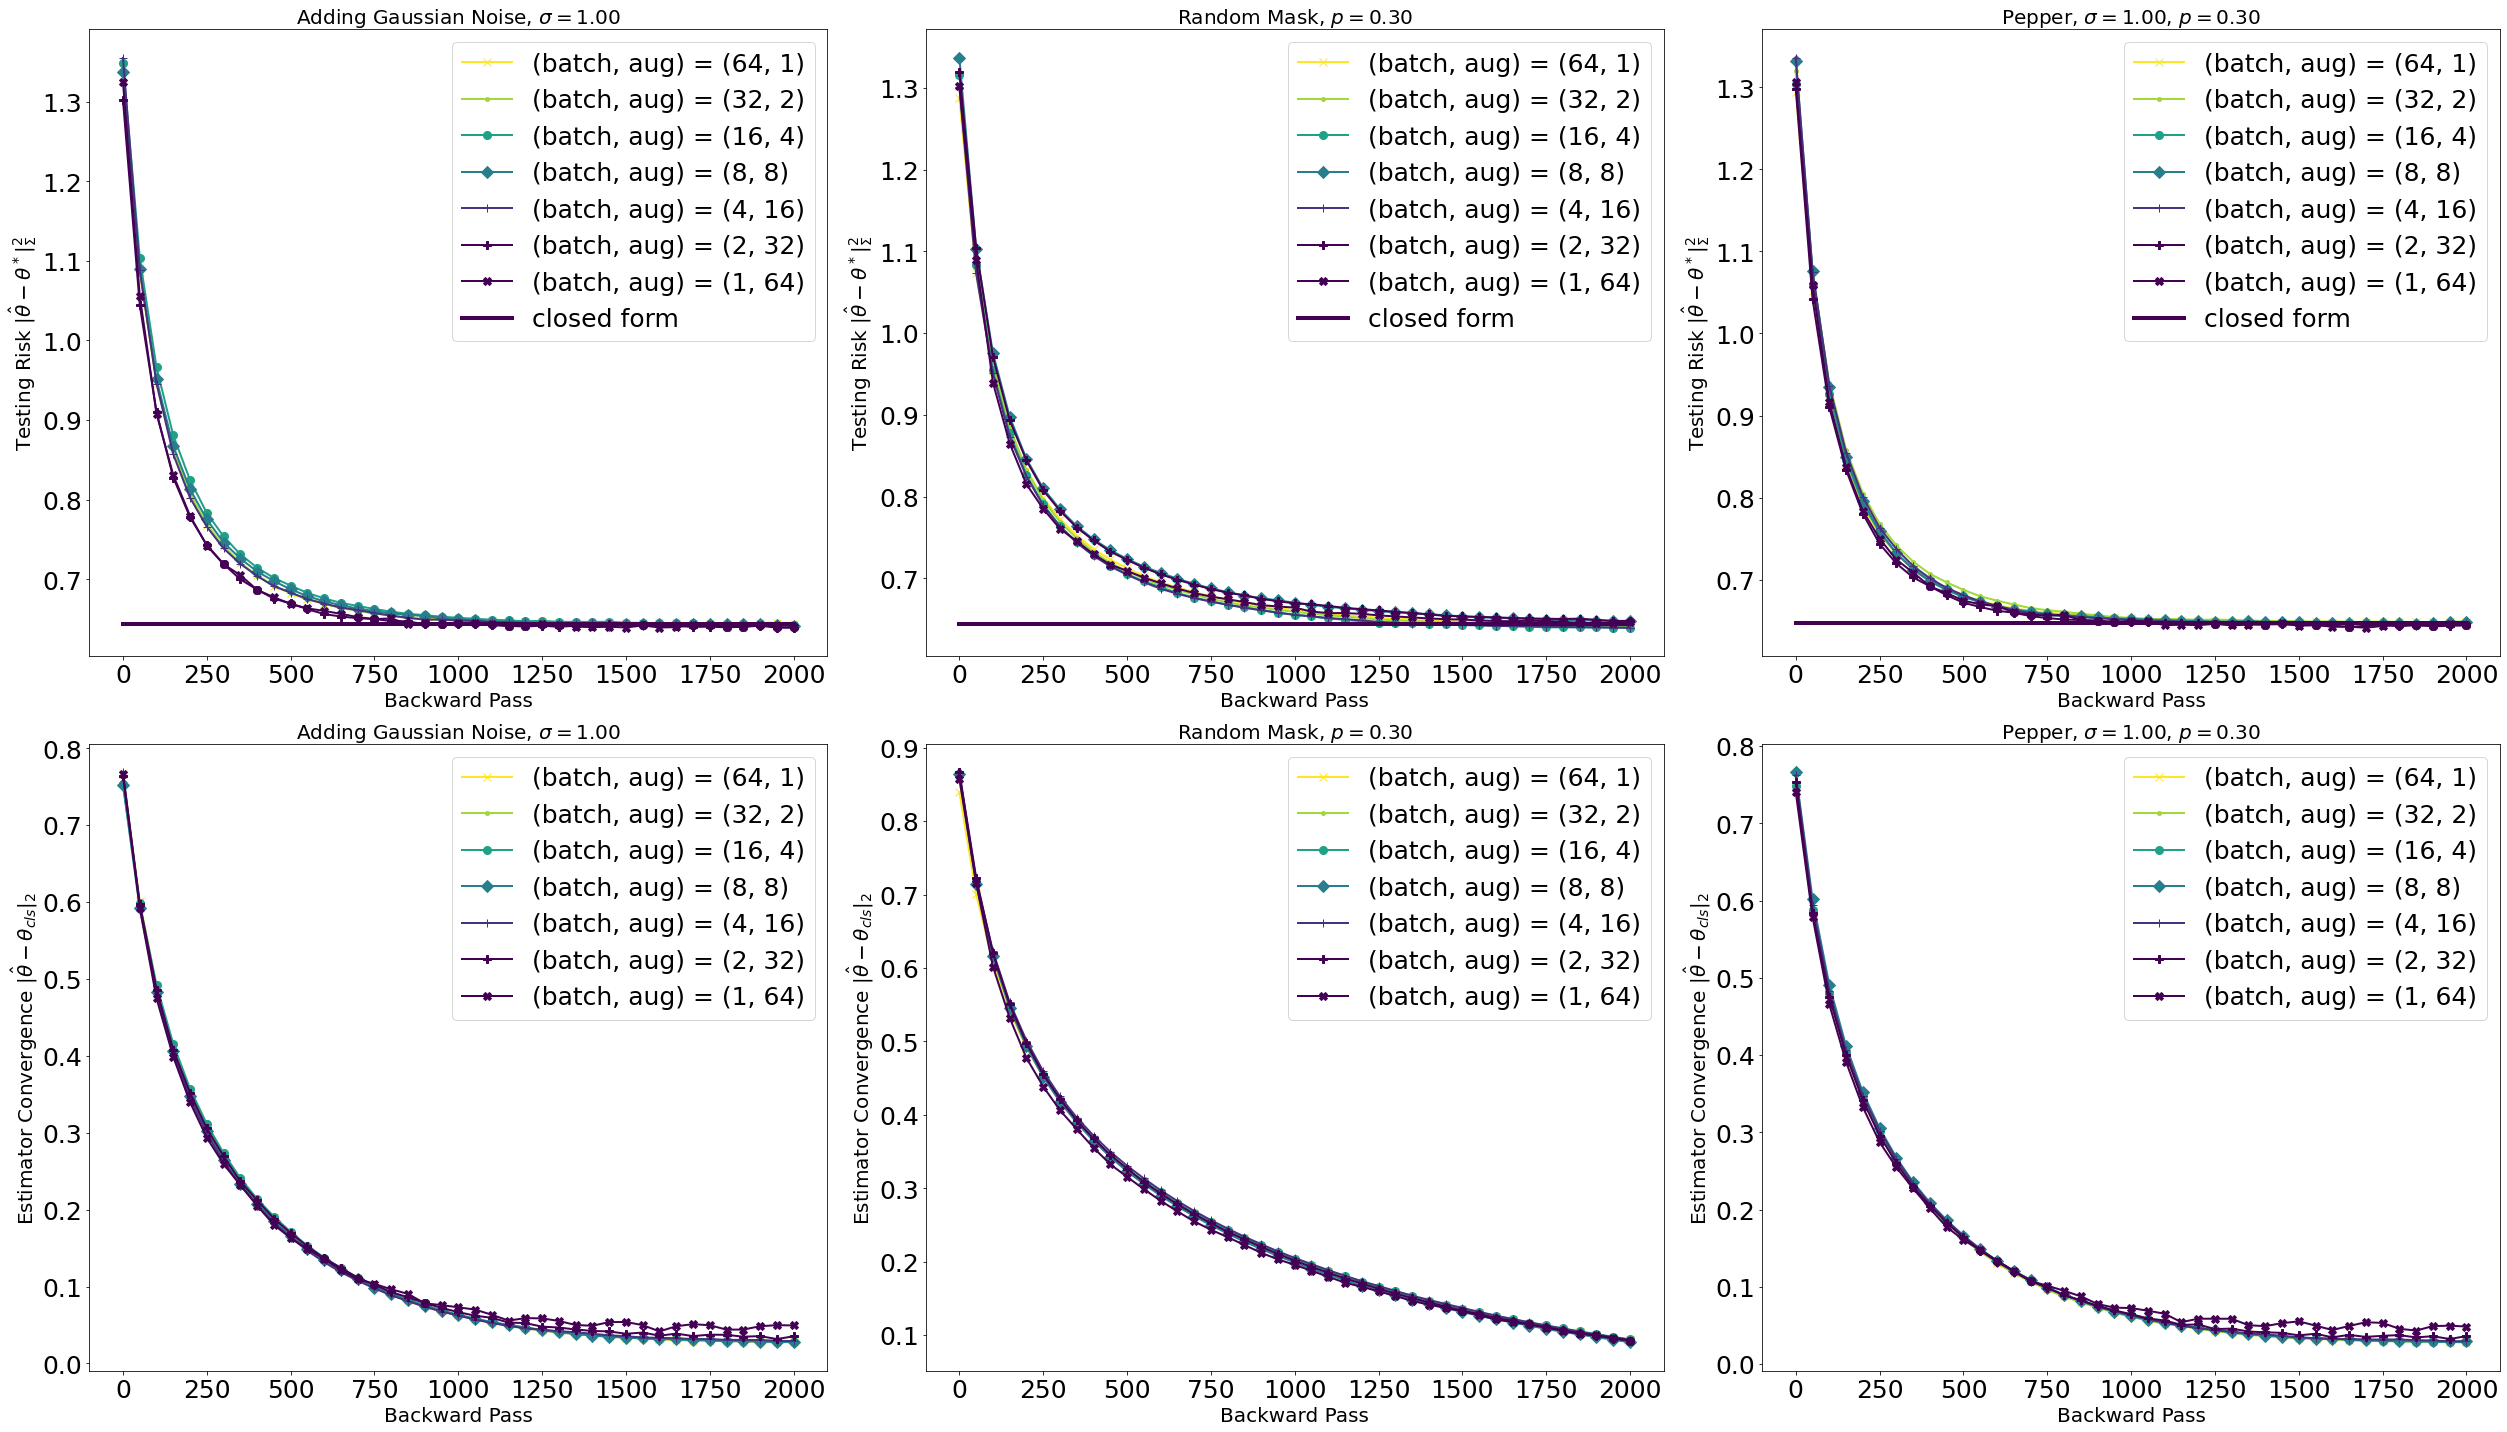

In [13]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 8)
linewidth = 2.0
tick_size = 25
marker = ['x', '.', 'o', 'D', '+', 'P', 'X']
markersize = 8

plt.figure(figsize=(35, 20))
plt.subplot(2,3,1)
x_ax = pass_list
for i in range(len(ridge_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, risk_ridge[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
    if ridge_params[i] > 0:
        plt.plot(x_ax, [risk_ridge_cls[i]] * len(x_ax), markersize=8,  linewidth=2*linewidth, c=viridis(-100), label= 'closed form')
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=20)
plt.ylabel('Testing Risk '+ r'$\|\hat{\theta}-\theta^*\|^2_{\Sigma}$', fontsize=20)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title(f"Adding Gaussian Noise, " + r'$\sigma=$'+format(round(np.sqrt(pepper_params[0]['ridge']),3), '.2f'), fontsize=20)

plt.subplot(2,3,2)
for i in range(len(crop_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, risk_crop[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
    if crop_params[i] > 0:
        plt.plot(x_ax, [risk_crop_cls[i]] * len(x_ax),  linewidth=2*linewidth, c=viridis(-100), label='closed form')
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=20)
plt.ylabel('Testing Risk '+ r'$\|\hat{\theta}-\theta^*\|^2_{\Sigma}$', fontsize=20)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title(f"Random Mask, " + r'$p=$'+format(round(pepper_params[0]['drop_prob'],3), '.2f'), fontsize=20)

plt.subplot(2,3,3)
for i in range(len(pepper_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, risk_pepper[i, m], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
    if pepper_params[i]['ridge']  > 0 or pepper_params[i]['drop_prob'] > 0:
        plt.plot(x_ax, [risk_pepper_cls[i]] * len(x_ax),  linewidth=2*linewidth, c=viridis(-100), label='closed form')
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=20)
plt.ylabel('Testing Risk '+ r'$\|\hat{\theta}-\theta^*\|^2_{\Sigma}$', fontsize=20)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title(f"Pepper, " + r'$\sigma=$'+format(round(np.sqrt(pepper_params[0]['ridge']),3), '.2f') + ', ' + r'$p=$'+format(round(pepper_params[0]['drop_prob'],3), '.2f'), fontsize=20)


ax = plt.subplot(2,3,4)
for i in range(len(ridge_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, toCLS_ridge[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=20)
ax.set_ylabel('Estimator Convergence ' + r'$\|\hat{\theta}-\theta_{cls}\|_2$', fontsize=20)
#ax1.set_ylabel(r'$\|\hat{\theta}-\theta_{lse}\|_2$', fontsize=20)
ax.tick_params(axis='y', labelsize=tick_size)
#ax1.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=tick_size)
plt.title(f"Adding Gaussian Noise, " + r'$\sigma=$'+format(round(np.sqrt(pepper_params[0]['ridge']),3), '.2f'), fontsize=20)


ax = plt.subplot(2,3,5)
for i in range(len(crop_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, toCLS_crop[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize)
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=20)
ax.set_ylabel('Estimator Convergence ' + r'$\|\hat{\theta}-\theta_{cls}\|_2$', fontsize=20)
#ax1.set_ylabel(r'$\|\hat{\theta}-\theta_{lse}\|_2$', fontsize=20)
ax.tick_params(axis='y', labelsize=tick_size)
#ax1.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=tick_size)
plt.title(f"Random Mask, " + r'$p=$'+format(round(pepper_params[0]['drop_prob'],3), '.2f'), fontsize=20)

ax = plt.subplot(2,3,6)
for i in range(len(pepper_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, toCLS_pepper[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=20)
ax.set_ylabel('Estimator Convergence ' + r'$\|\hat{\theta}-\theta_{cls}\|_2$', fontsize=20)
ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='x', labelsize=tick_size)
#plt.yscale('log')
plt.title(f"Pepper, " + r'$\sigma=$'+format(round(np.sqrt(pepper_params[0]['ridge']),3), '.2f') + ', ' + r'$p=$'+format(round(pepper_params[0]['drop_prob'],3), '.2f'), fontsize=20)

#plt.suptitle(f'SNR = {snr: 0.2f}, dimension = {ambient_dimension}, num_sample = {num_sample}',fontsize=30, y=1.05)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Pepper, $\\sigma=$1.00, $p=$0.30')

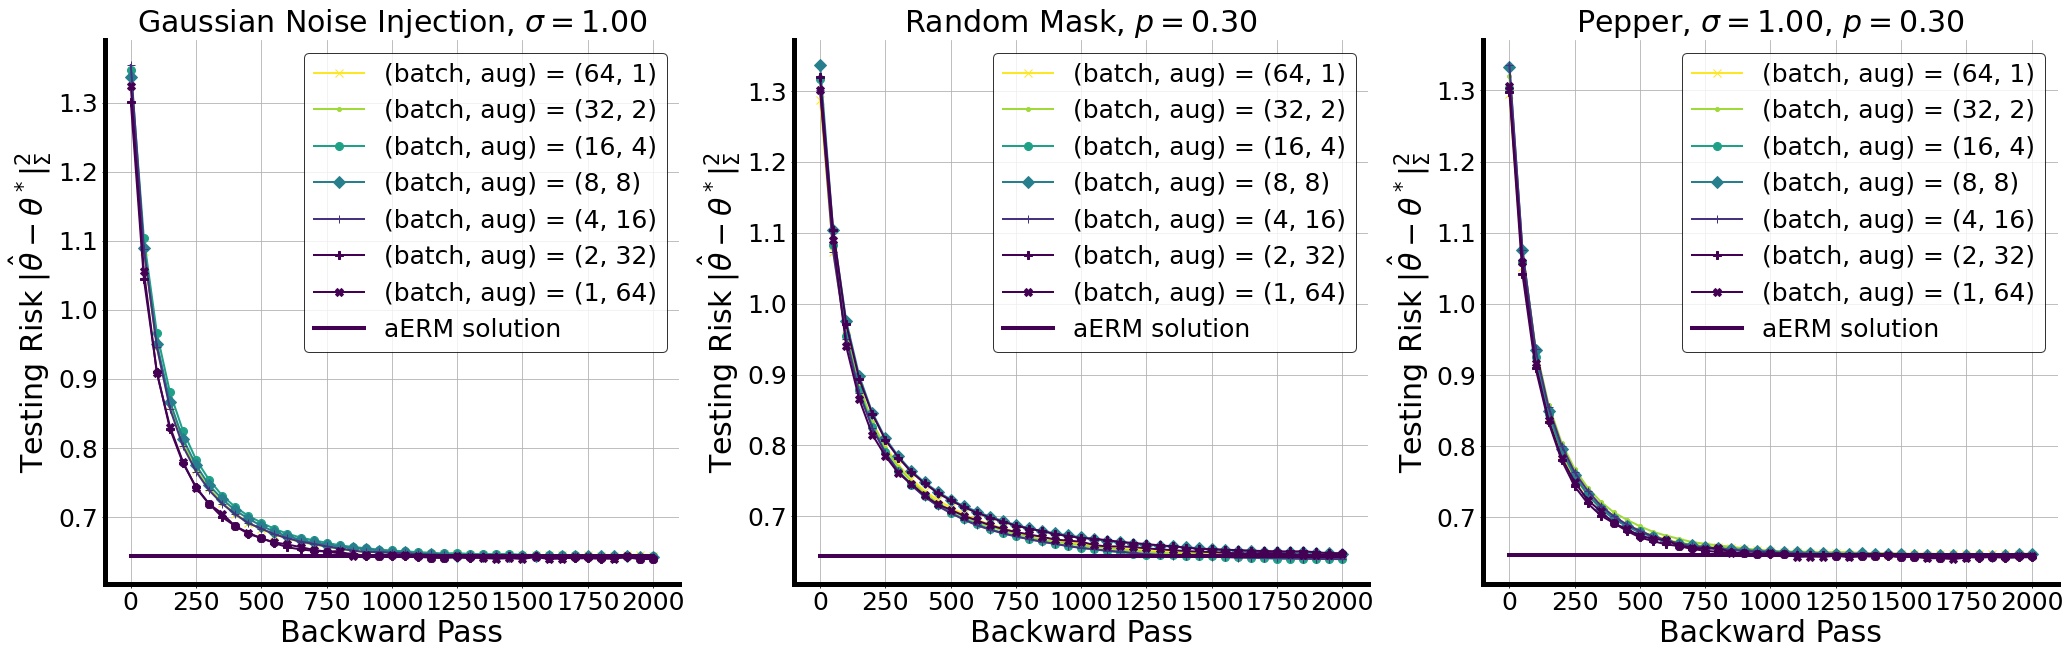

In [18]:
plt.figure(figsize=(35, 10))
ax = plt.subplot(1,3,1)
x_ax = pass_list
legendsize = 25
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 5
for i in range(len(ridge_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, risk_ridge[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
    if ridge_params[i] > 0:
        plt.plot(x_ax, [risk_ridge_cls[i]] * len(x_ax), markersize=8,  linewidth=2*linewidth, c=viridis(-100), label= 'aERM solution')
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=30)
plt.ylabel('Testing Risk '+ r'$\|\hat{\theta}-\theta^*\|^2_{\Sigma}$', fontsize=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(True)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.title(f"Gaussian Noise Injection, " + r'$\sigma=$'+format(round(np.sqrt(pepper_params[0]['ridge']),3), '.2f'), fontsize=30)

ax = plt.subplot(1,3,2)
for i in range(len(crop_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, risk_crop[i, m, :], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
    if crop_params[i] > 0:
        plt.plot(x_ax, [risk_crop_cls[i]] * len(x_ax),  linewidth=2*linewidth, c=viridis(-100), label='aERM solution')
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=30)
plt.ylabel('Testing Risk '+ r'$\|\hat{\theta}-\theta^*\|^2_{\Sigma}$', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.title(f"Random Mask, " + r'$p=$'+format(round(pepper_params[0]['drop_prob'],3), '.2f'), fontsize=30)

ax = plt.subplot(1,3,3)
for i in range(len(pepper_params)):
    for m in range(len(batch_aug_list)):
        batch_size, aug_size = batch_aug_list[m]
        plt.plot(x_ax, risk_pepper[i, m], label='(batch, aug) = (' + format(batch_size) + \
                                                      ', ' + format(aug_size) + ')', linewidth=linewidth, c=viridis(0.2 * (len(batch_aug_list) - m - 2)), marker=marker[m], markersize=markersize) # Gaussian noise
    if pepper_params[i]['ridge']  > 0 or pepper_params[i]['drop_prob'] > 0:
        plt.plot(x_ax, [risk_pepper_cls[i]] * len(x_ax),  linewidth=2*linewidth, c=viridis(-100), label='aERM solution')
plt.legend(loc="upper right", prop={'size': 25})
plt.xlabel('Backward Pass', fontsize=30)
plt.ylabel('Testing Risk '+ r'$\|\hat{\theta}-\theta^*\|^2_{\Sigma}$', fontsize=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid(True)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.title(f"Pepper, " + r'$\sigma=$'+format(round(np.sqrt(pepper_params[0]['ridge']),3), '.2f') + ', ' + r'$p=$'+format(round(pepper_params[0]['drop_prob'],3), '.2f'), fontsize=30)